# Task 1



# Imports

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import librosa
from tqdm import tqdm
sns.set()
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.metrics import confusion_matrix

In [ ]:
!pip install essentia

     |████████████████████████████████| 12.0MB 285kB/s 


In [ ]:
import essentia as es
from essentia.standard import *

# Colab-Drive Linking

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
address_folder = "/content/drive/MyDrive/genres" 

# Global Constants 

In [ ]:
TOTAL_SAMPLES = 661500 #30sec * 22050Hz


# Load Audio Files

In [ ]:
set1 = ['classical', 'hiphop', 'metal', 'disco', 'reggae']
set2 = ['pop', 'rock', 'country', 'jazz', 'blues']

def load_files(address, set):
  labels = []
  audio = []
  # for i in tqdm(len(set)):
  #   genre = set[i]
  for genre in tqdm(set):
    print("Genre: {}".format(genre))
    path_of_audios = librosa.util.find_files(address + "/" + genre)
    for each in tqdm(path_of_audios):
      x , sr = librosa.load(each)
      audio.append(x)
      labels.append(genre)
  
  return audio,labels



In [ ]:
def get_rhythmic_files(address, set):
  audio = []
  for genre in tqdm(set):
    print("Genre: {}".format(genre))
    path_of_audios = librosa.util.find_files(address + "/" + genre)
    for each in tqdm(path_of_audios):
      audio.append(MonoLoader(filename=each)())
  return np.array(audio, dtype=object)

In [ ]:
files_set1,labels_set1 = load_files(address_folder,set1)
files_set2,labels_set2 = load_files(address_folder,set2)


In [ ]:
files_set1_numpy = np.array(files_set1, dtype = object)

files_set2_numpy = np.array(files_set2, dtype = object)


In [ ]:
labels_set1_numpy = np.array(labels_set1, dtype = object)
labels_set2_numpy = np.array(labels_set2, dtype = object)

In [ ]:
np.save('/content/drive/MyDrive/MMT/files_set1',files_set1_numpy)
np.save('/content/drive/MyDrive/MMT/files_set2', files_set2_numpy)


In [ ]:
np.save('/content/drive/MyDrive/MMT/labels_set1',labels_set1_numpy)
np.save('/content/drive/MyDrive/MMT/labels_set2',labels_set2_numpy)

In [ ]:
files_set1_numpy = np.load('/content/drive/MyDrive/MMT/files_set1.npy',allow_pickle=True)
files_set2_numpy = np.load('/content/drive/MyDrive/MMT/files_set2.npy',allow_pickle=True)


In [ ]:
labels_set1_numpy = np.load('/content/drive/MyDrive/MMT/labels_set1.npy',allow_pickle=True)
labels_set2_numpy = np.load('/content/drive/MyDrive/MMT/labels_set2.npy',allow_pickle=True)

In [ ]:
rhythm_files_set1_numpy = get_rhythmic_files(address_folder,set1)
rhythm_files_set2_numpy = get_rhythmic_files(address_folder,set2)

  0%|          | 0/100 [00:00<?, ?it/s]

Genre: classical



 20%|██        | 1/5 [01:44<06:59, 104.98s/it]

Genre: hiphop



 40%|████      | 2/5 [03:22<05:08, 102.72s/it]

Genre: metal



 60%|██████    | 3/5 [05:02<03:23, 101.99s/it]

Genre: disco



 80%|████████  | 4/5 [06:42<01:41, 101.28s/it]

Genre: reggae



  0%|          | 0/5 [00:00<?, ?it/s]

Genre: pop



 20%|██        | 1/5 [01:36<06:26, 96.70s/it]

Genre: rock



 40%|████      | 2/5 [03:16<04:53, 97.75s/it]

Genre: country



 60%|██████    | 3/5 [04:56<03:16, 98.18s/it]

Genre: jazz



 80%|████████  | 4/5 [06:32<01:37, 97.70s/it]

Genre: blues



100%|██████████| 5/5 [08:11<00:00, 98.38s/it]


In [ ]:
#load rhythmic files

with open('/content/drive/MyDrive/rhythm/set1/audio_rhythm_set1.pkl', 'rb') as f:
  rhythm_files_set1_numpy = np.array(pickle.load(f), dtype=object)
with open('/content/drive/MyDrive/rhythm/set2/audio_rhythm_set1.pkl', 'rb') as f:
  rhythm_files_set2_numpy = np.array(pickle.load(f), dtype=object)


# Feature Extraction

In [ ]:
def get_timbral_features(files,tw,aw):

  total_parts_file = int(30/tw)
  samples_per_tw = int(TOTAL_SAMPLES/total_parts_file)
  aw_per_tw = int(tw/aw)
  samples_per_aw_per_tw = int(samples_per_tw/aw_per_tw)
  ans_feature_mat = []
  for file in tqdm(files):
    spectral_centroid = np.array(librosa.feature.spectral_centroid(y=file, sr=22050, n_fft=samples_per_aw_per_tw, hop_length=samples_per_aw_per_tw)[0])
    spectral_rolloff = np.array(librosa.feature.spectral_rolloff(y=file, sr=22050, n_fft=samples_per_aw_per_tw, hop_length=samples_per_aw_per_tw)[0])
    spectral_flux = np.array(librosa.onset.onset_strength(y=file, sr=22050, center=True))
    zero_crossing = librosa.feature.zero_crossing_rate(y=file, frame_length=samples_per_aw_per_tw, hop_length=samples_per_aw_per_tw)
    mfcc = np.array(librosa.feature.mfcc(y=file, sr=22050, n_fft=samples_per_aw_per_tw, hop_length=samples_per_aw_per_tw)[:5,:])
    rmse = np.array(librosa.feature.rms(file, frame_length = samples_per_aw_per_tw, hop_length = samples_per_aw_per_tw)[0])

    # print(type(zero_crossing))
    total_aw = len(spectral_centroid)
    temp_mat = np.zeros((total_aw,17))
    feature_row = [] 
    step = aw_per_tw
    for texture_index in range(total_parts_file):
      temp_mat[texture_index][0] = np.mean(spectral_centroid[step*texture_index:step*(texture_index+1)])
      temp_mat[texture_index][1] = np.var(spectral_centroid[step*texture_index:step*(texture_index+1)])
            
      temp_mat[texture_index][2] = np.mean(spectral_rolloff[step*texture_index:step*(texture_index+1)])
      temp_mat[texture_index][3] = np.var(spectral_rolloff[step*texture_index:step*(texture_index+1)])

      temp_mat[texture_index][4] = np.mean(zero_crossing[0][step*texture_index:step*(texture_index+1)])
      temp_mat[texture_index][5] = np.var(zero_crossing[0][step*texture_index:step*(texture_index+1)])

      texture_window = rmse[step*texture_index:step*(texture_index+1)]
      rmse_mean = np.mean(rmse[step*texture_index:step*(texture_index+1)])
      low_energy = len(texture_window[np.where(texture_window < rmse_mean)])/float(len(texture_window))
      temp_mat[texture_index][6] = low_energy

      texture_window_mean = np.mean(mfcc[:,step*texture_index:step*(texture_index+1)], axis=1)
      texture_window_var = np.var(mfcc[:,step*texture_index:step*(texture_index+1)], axis=1)

      for row,col in enumerate(range(7,17,2)):
        temp_mat[texture_index][col] = texture_window_mean[row]
        temp_mat[texture_index][1+col] = texture_window_var[row]

    feature_row = np.mean(temp_mat, axis=0).tolist() 
    feature_row += [np.mean(spectral_flux), np.var(spectral_flux)]

    feature_row = np.array(feature_row)
    ans_feature_mat.append(feature_row)
  
  return ans_feature_mat
    

In [ ]:
def get_rhythm_features(files):
  # Compute beat positions and BPM
  rh_features_mat = []
  for audio in tqdm(files):
    temp_row = []
    rhythm_extractor = RhythmExtractor2013(method="multifeature")
    bpm, beats, beatsconfidence, _, beats_intervals = rhythm_extractor(audio)
    peak1_bpm, peak1_weight, peak1_spread, peak2_bpm, peak2_weight, peak2_spread, histogram = BpmHistogramDescriptors()(beats_intervals)
    temp_row += [peak1_weight/np.sum(histogram), peak2_weight/np.sum(histogram), peak2_weight/peak1_weight, peak1_bpm, peak2_bpm, sum(histogram)]
    rh_features_mat.append(np.array(temp_row))
  
  return np.array(rh_features_mat)

In [ ]:
# get pitch features
import os
from xml.etree import ElementTree
def get_pitch_features(address_filename):
    file_name = address_filename
    full_file = os.path.abspath(os.path.join("", file_name))
    dom = ElementTree.parse(full_file)
    audios = dom.findall("data_set")

    all_features_matrix = []
    for audio in audios:
        all_features =  audio.findall("feature")

        all_feature_one_file = []
        for f in all_features:
            values = f.findall("v")
            for v in values:
                all_feature_one_file.append(float(v.text))
            
        all_features_matrix.append(np.array(all_feature_one_file, dtype=object))

    return np.array(all_features_matrix, dtype=object)

# Different Classifiers
  


### K-Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def knn_model(X_tr,Y_tr,X_te,Y_te):
  test_scores, train_scores = [],[]

  for i in tqdm(range(1,15,1)):

      knn = KNeighborsClassifier(i)
      knn.fit(X_tr,Y_tr)
      
      train_scores.append(knn.score(X_tr,Y_tr))
      test_scores.append(knn.score(X_te,Y_te))
  max_test_score = max(test_scores)
  test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
  print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))
  return train_scores, test_scores

def knn_get_visualization(train_scores, test_scores):
  plt.figure(figsize=(12,5))
  p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
  p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')


  ### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
def logReg_model(X_tr,Y_tr,X_te,Y_te):
  logReg = LogisticRegression(solver='lbfgs', max_iter=10000)
  logReg.fit(X_tr,Y_tr)
  predictions = logReg.predict(X_te)  
  score = logReg.score(x_test, y_test)
  print("The accuracy is:  {}".format(score))


### SVM

In [ ]:
from sklearn import svm
def svm_model(X_tr,Y_tr,X_te,Y_te):
  classifier = svm.SVC(kernel='linear')
  classifier.fit(X_tr,Y_tr)
  prediction_SVM_all = classifier.predict(X_te)
  cm = confusion_matrix(Y_te, prediction_SVM_all)
  print("The accuracy is: "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
def dt_model(X_tr,Y_tr,X_te,Y_te):
  clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
  clf = clf.fit(X_tr,Y_tr)
  y_pred = clf.predict(X_te)
  print("The accuracy is: ",metrics.accuracy_score(Y_te, y_pred))

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def rf_model(X_tr,Y_tr,X_te,Y_te):
  clf=RandomForestClassifier(n_estimators=100)
  clf.fit(X_tr,Y_tr)
  print("The accuracy is: ",metrics.accuracy_score(Y_te,clf.predict(X_te)))

# Rhythmic Feature Extraction

In [ ]:
rhythmic_features_set1 = get_rhythm_features(rhythm_files_set1_numpy)
rhythmic_features_set2 = get_rhythm_features(rhythm_files_set2_numpy)

100%|██████████| 500/500 [08:07<00:00,  1.03it/s]


In [ ]:
np.save('/content/drive/MyDrive/MMT/rhythmic_features_set1',rhythmic_features_set1)
np.save('/content/drive/MyDrive/MMT/rhythmic_features_set2',rhythmic_features_set2)

In [ ]:
rhythmic_features_set1 = np.load('/content/drive/MyDrive/MMT/rhythmic_features_set1.npy',allow_pickle=True)
rhythmic_features_set2 = np.load('/content/drive/MyDrive/MMT/rhythmic_features_set2.npy',allow_pickle=True)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
rhythmic_features_n_set1 = min_max_scaler.fit_transform(rhythmic_features_set1)
rhythmic_features_n_set2 = min_max_scaler.fit_transform(rhythmic_features_set2)

# Pitch Feature Extraction

In [ ]:
pitch_feature_set1 = get_pitch_features("/content/drive/MyDrive/MMT/pitch_features_set1.xml")
pitch_feature_set2 = get_pitch_features("/content/drive/MyDrive/MMT/pitch_features_set2.xml")

In [ ]:
np.save('/content/drive/MyDrive/MMT/pitch_feature_set1',pitch_feature_set1)
np.save('/content/drive/MyDrive/MMT/pitch_feature_set2',pitch_feature_set2)

In [ ]:
pitch_feature_set1 = np.load('/content/drive/MyDrive/MMT/pitch_feature_set1.npy',allow_pickle=True)
pitch_feature_set2 = np.load('/content/drive/MyDrive/MMT/pitch_feature_set2.npy',allow_pickle=True)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
pitch_feature_n_set1 = min_max_scaler.fit_transform(pitch_feature_set1)
pitch_feature_n_set2 = min_max_scaler.fit_transform(rhythmic_features_set2)

# Feature Subsets

## Texture Window: 5sec
 

 ### Analysis Window: 25 msec

In [ ]:
tw = 5
aw = 0.025

In [ ]:
feature_mat_set1 = get_timbral_features(files_set1_numpy,tw,aw)
feature_mat_set2 = get_timbral_features(files_set2_numpy,tw,aw)
feature_mat_set1 = np.array(feature_mat_set1, dtype='float64')
feature_mat_set2 = np.array(feature_mat_set2, dtype='float64')

100%|██████████| 500/500 [01:39<00:00,  5.04it/s]


In [ ]:
#normalize
min_max_scaler = preprocessing.MinMaxScaler()
feature_mat_n_set1 = min_max_scaler.fit_transform(feature_mat_set1)
feature_mat_n_set2 = min_max_scaler.fit_transform(feature_mat_set2)

In [ ]:
np.save('/content/drive/MyDrive/MMT/feature_mat_set1',feature_mat_set1)
np.save('/content/drive/MyDrive/MMT/feature_mat_set2',feature_mat_set2)

In [ ]:
feature_mat_set1 = np.load('/content/drive/MyDrive/MMT/feature_mat_set1.npy',allow_pickle=True)
feature_mat_set2 = np.load('/content/drive/MyDrive/MMT/feature_mat_set2.npy',allow_pickle=True)

In [ ]:
corr_set_1 = np.corrcoef(feature_mat_set1.T)
corr_set_2 = np.corrcoef(feature_mat_set2.T)

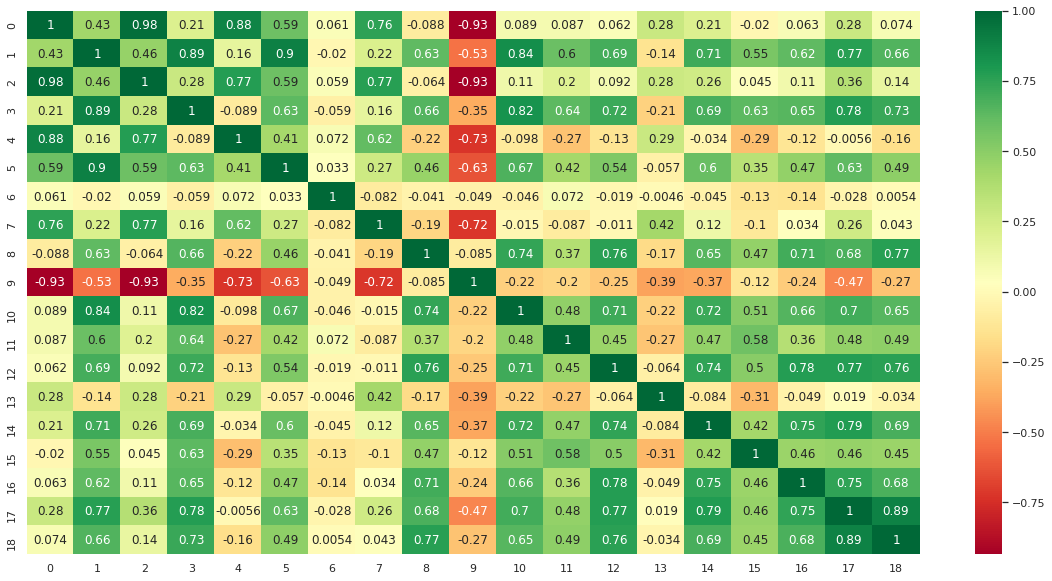

In [ ]:
plt.figure(figsize=(20,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(corr_set_1, annot=True,cmap ='RdYlGn')

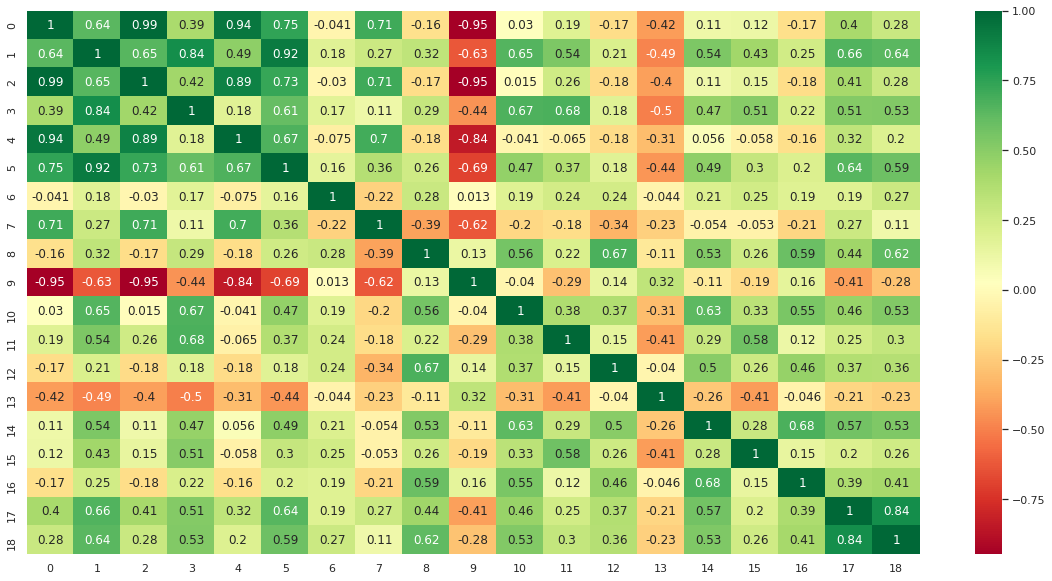

In [ ]:
plt.figure(figsize=(20,10))  # on this line I just set the size of figure to 20 by 10.
p=sns.heatmap(corr_set_2, annot=True,cmap ='RdYlGn')

#### Set1

##### Only Timbral Features

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_mat_n_set1, labels_set1_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 33.38it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 82.0 % and k = [7]


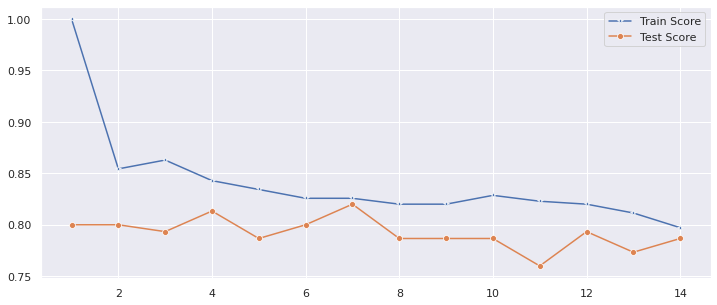

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.8266666666666667


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.9428571428571428


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.72


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.8


##### Timbral Features + Rhythmic Features

In [ ]:
tr_feature_mat_set1 = np.concatenate((feature_mat_n_set1,rhythmic_features_n_set1), axis=1 )

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tr_feature_mat_set1, labels_set1_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 30.99it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 78.66666666666666 % and k = [14]


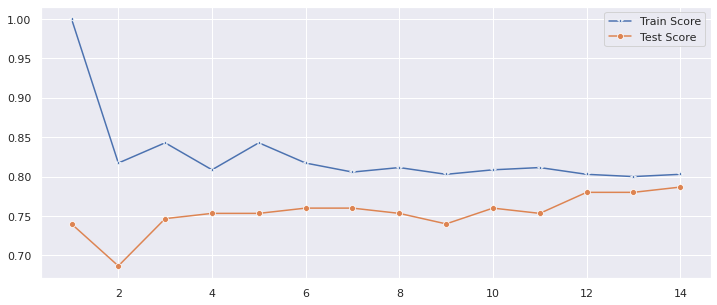

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.76


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.8857142857142857


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7066666666666667


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.8066666666666666


##### Timbral Features + Rhythmic Features + Pitch Features



In [ ]:
tr_feature_mat_set1 = np.concatenate((feature_mat_n_set1,rhythmic_features_n_set1), axis=1 )
trp_feature_mat_set1 = np.concatenate((tr_feature_mat_set1, pitch_feature_n_set1), axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(trp_feature_mat_set1, labels_set1_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 28.46it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 78.0 % and k = [6]


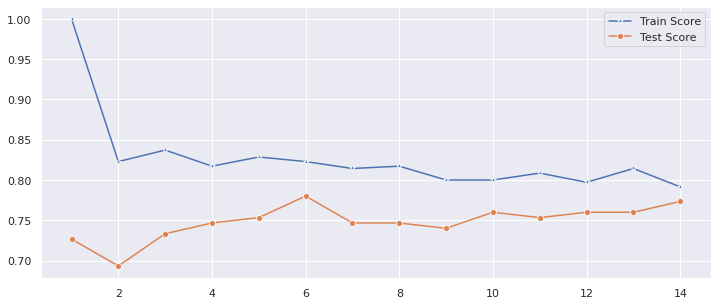

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.78


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.9


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7066666666666667


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.8


#### Set2

##### Only Timbral Features

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_mat_n_set2, labels_set2_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 31.04it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 73.33333333333333 % and k = [8]


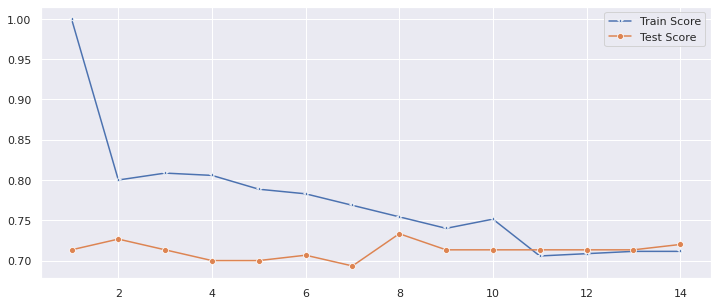

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.62


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.49122807017543857


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.5733333333333334


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7533333333333333


##### Timbral Features + Rhythmic Features

In [ ]:
tr_feature_mat_set2 = np.concatenate((feature_mat_n_set2,rhythmic_features_n_set2), axis=1 )

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tr_feature_mat_set2, labels_set2_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 29.24it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 68.66666666666667 % and k = [13]


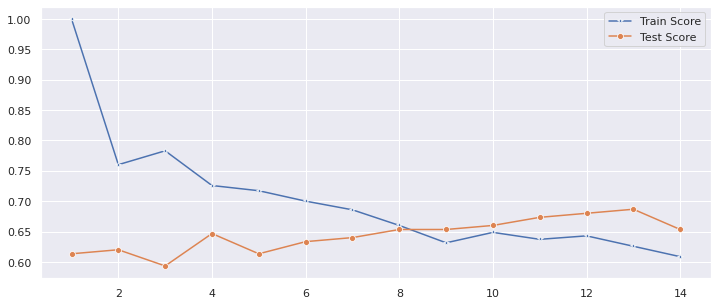

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.6466666666666666


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.5789473684210527


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.5733333333333334


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7266666666666667


##### Timbral Features + Rhythmic Features + Pitch Features



In [ ]:
tr_feature_mat_set2 = np.concatenate((feature_mat_n_set2,rhythmic_features_n_set2), axis=1 )
trp_feature_mat_set2 = np.concatenate((tr_feature_mat_set2, pitch_feature_n_set2), axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(trp_feature_mat_set2, labels_set2_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 28.35it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 64.0 % and k = [14]


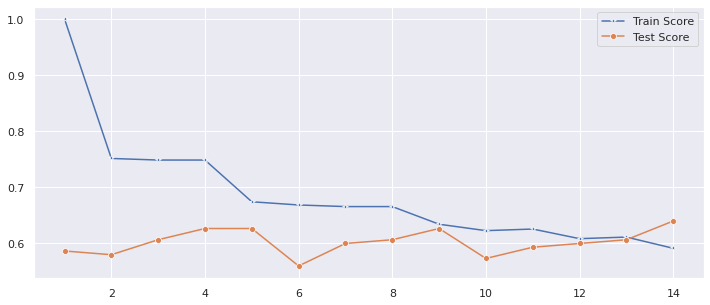

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.6533333333333333


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.6140350877192983


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.5666666666666667


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.72


 ### Analysis Window: 75 msec

In [ ]:
tw = 5
aw = 0.075

In [ ]:
feature_mat_set1 = get_timbral_features(files_set1_numpy,tw,aw)
feature_mat_set2 = get_timbral_features(files_set2_numpy,tw,aw)
feature_mat_set1 = np.array(feature_mat_set1, dtype='float64')
feature_mat_set2 = np.array(feature_mat_set2, dtype='float64')

100%|██████████| 500/500 [02:12<00:00,  3.77it/s]


In [ ]:
#normalize
min_max_scaler = preprocessing.MinMaxScaler()
feature_mat_n_set1 = min_max_scaler.fit_transform(feature_mat_set1)
feature_mat_n_set2 = min_max_scaler.fit_transform(feature_mat_set2)

In [ ]:
np.save('/content/drive/MyDrive/MMT/feature_mat_set1',feature_mat_set1)
np.save('/content/drive/MyDrive/MMT/feature_mat_set2',feature_mat_set2)

In [ ]:
feature_mat_set1 = np.load('/content/drive/MyDrive/MMT/feature_mat_set1.npy',allow_pickle=True)
feature_mat_set2 = np.load('/content/drive/MyDrive/MMT/feature_mat_set2.npy',allow_pickle=True)

In [ ]:
corr_set_1 = np.corrcoef(feature_mat_set1.T)
corr_set_2 = np.corrcoef(feature_mat_set2.T)

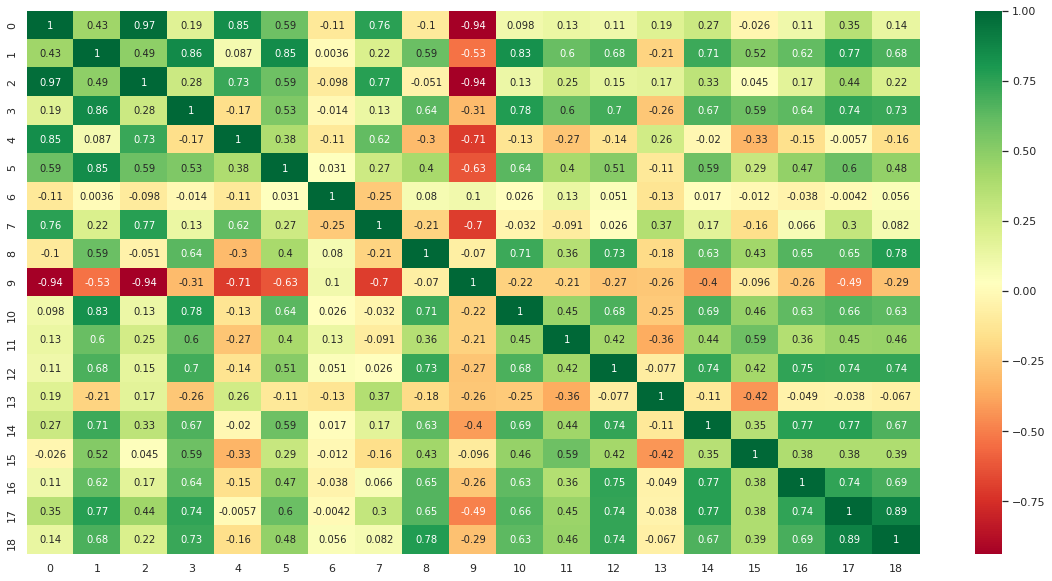

In [ ]:
plt.figure(figsize=(20,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(corr_set_1, annot=True,cmap ='RdYlGn')

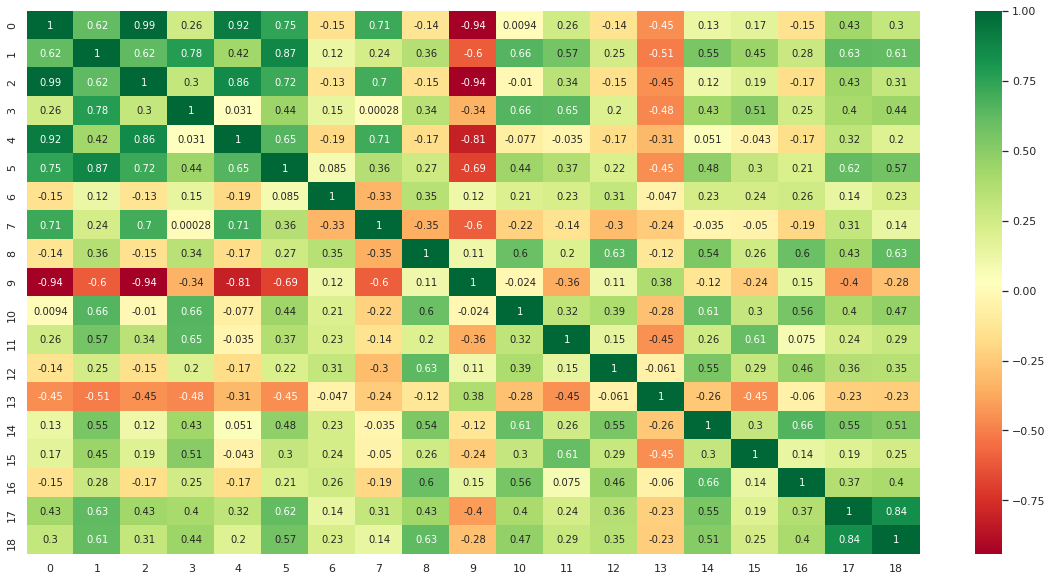

In [ ]:
plt.figure(figsize=(20,10))  # on this line I just set the size of figure to 20 by 10.
p=sns.heatmap(corr_set_2, annot=True,cmap ='RdYlGn')

#### Set1

##### Only Timbral Features

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_mat_n_set1, labels_set1_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 31.70it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 78.66666666666666 % and k = [7]


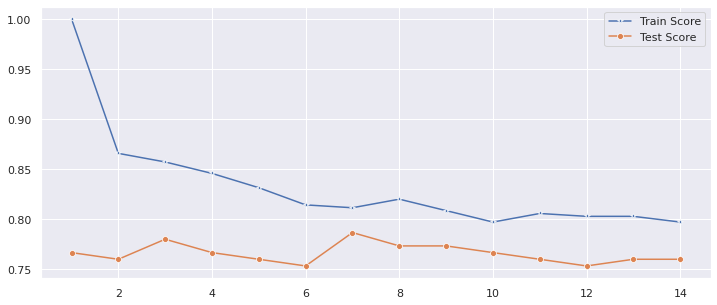

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.8066666666666666


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.8857142857142857


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.72


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.78


##### Timbral Features + Rhythmic Features

In [ ]:
tr_feature_mat_set1 = np.concatenate((feature_mat_n_set1,rhythmic_features_n_set1), axis=1 )

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tr_feature_mat_set1, labels_set1_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 28.39it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 77.33333333333333 % and k = [10]


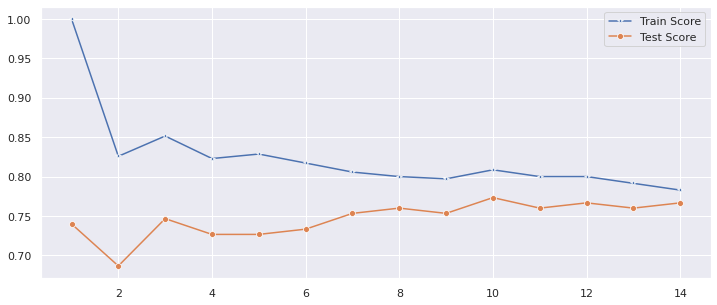

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.76


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.8571428571428571


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.72


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7933333333333333


##### Timbral Features + Rhythmic Features + Pitch Features



In [ ]:
tr_feature_mat_set1 = np.concatenate((feature_mat_n_set1,rhythmic_features_n_set1), axis=1 )
trp_feature_mat_set1 = np.concatenate((tr_feature_mat_set1, pitch_feature_n_set1), axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(trp_feature_mat_set1, labels_set1_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 29.07it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 78.0 % and k = [10, 12]


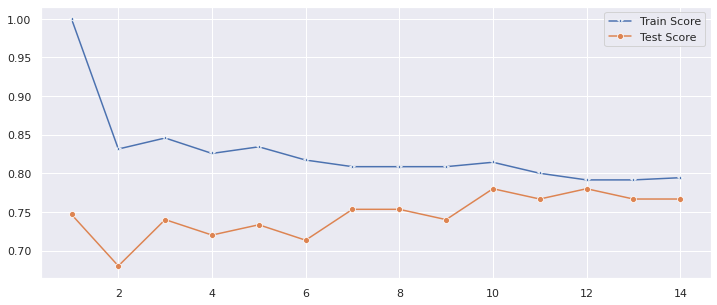

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7666666666666667


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.8571428571428571


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.72


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7733333333333333


#### Set2

##### Only Timbral Features

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_mat_n_set2, labels_set2_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 30.78it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 75.33333333333333 % and k = [11]


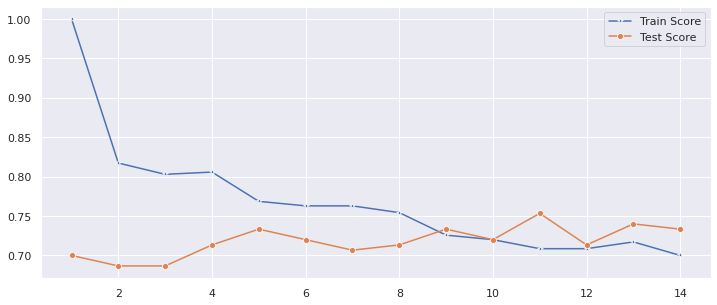

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.6266666666666667


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.49122807017543857


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.5533333333333333


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.74


##### Timbral Features + Rhythmic Features

In [ ]:
tr_feature_mat_set2 = np.concatenate((feature_mat_n_set2,rhythmic_features_n_set2), axis=1 )

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tr_feature_mat_set2, labels_set2_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 28.80it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 68.66666666666667 % and k = [7, 14]


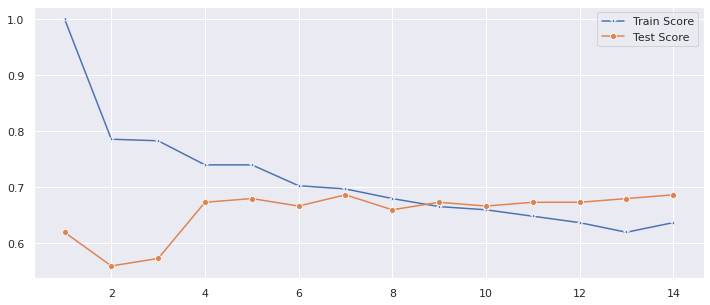

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.66


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.5263157894736842


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.5533333333333333


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.72


##### Timbral Features + Rhythmic Features + Pitch Features



In [ ]:
tr_feature_mat_set2 = np.concatenate((feature_mat_n_set2,rhythmic_features_n_set2), axis=1 )
trp_feature_mat_set2 = np.concatenate((tr_feature_mat_set2, pitch_feature_n_set2), axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(trp_feature_mat_set2, labels_set2_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 27.06it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 64.0 % and k = [14]


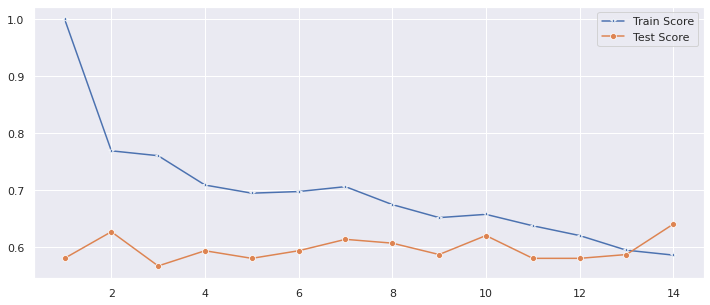

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.6533333333333333


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.5964912280701754


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.5533333333333333


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7533333333333333


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_mat_set2, labels_set2_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 46.91it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 42.0 % and k = [13]


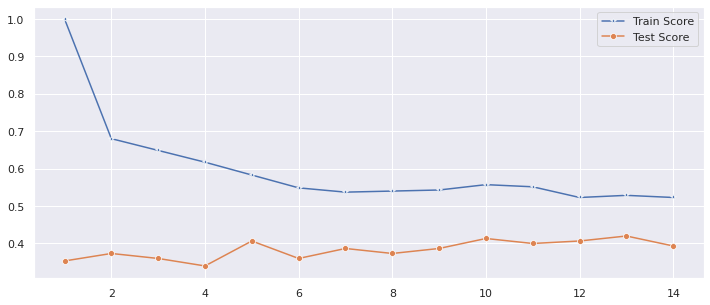

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.62


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.3157894736842105


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.5533333333333333


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7133333333333334


 ### Analysis Window: 120 msec

In [ ]:
tw = 5
aw = 0.120

In [ ]:
feature_mat_set1 = get_timbral_features(files_set1_numpy,tw,aw)
feature_mat_set2 = get_timbral_features(files_set2_numpy,tw,aw)
feature_mat_set1 = np.array(feature_mat_set1, dtype='float64')
feature_mat_set2 = np.array(feature_mat_set2, dtype='float64')

100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


In [ ]:
#normalize
min_max_scaler = preprocessing.MinMaxScaler()
feature_mat_n_set1 = min_max_scaler.fit_transform(feature_mat_set1)
feature_mat_n_set2 = min_max_scaler.fit_transform(feature_mat_set2)

In [ ]:
np.save('/content/drive/MyDrive/MMT/feature_mat_set1',feature_mat_set1)
np.save('/content/drive/MyDrive/MMT/feature_mat_set2',feature_mat_set2)

In [ ]:
feature_mat_set1 = np.load('/content/drive/MyDrive/MMT/feature_mat_set1.npy',allow_pickle=True)
feature_mat_set2 = np.load('/content/drive/MyDrive/MMT/feature_mat_set2.npy',allow_pickle=True)

In [ ]:
corr_set_1 = np.corrcoef(feature_mat_set1.T)
corr_set_2 = np.corrcoef(feature_mat_set2.T)

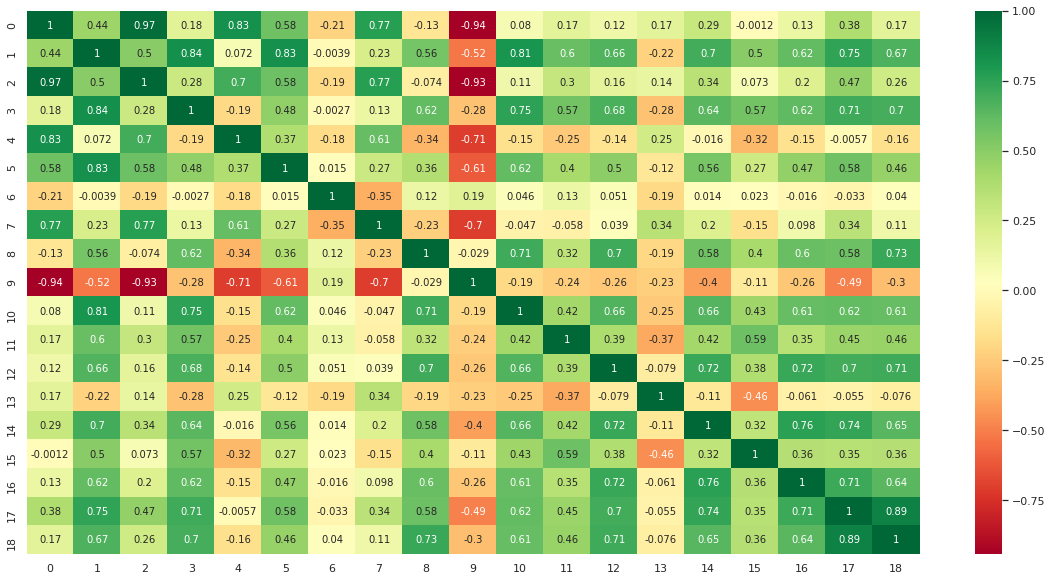

In [ ]:
plt.figure(figsize=(20,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(corr_set_1, annot=True,cmap ='RdYlGn')

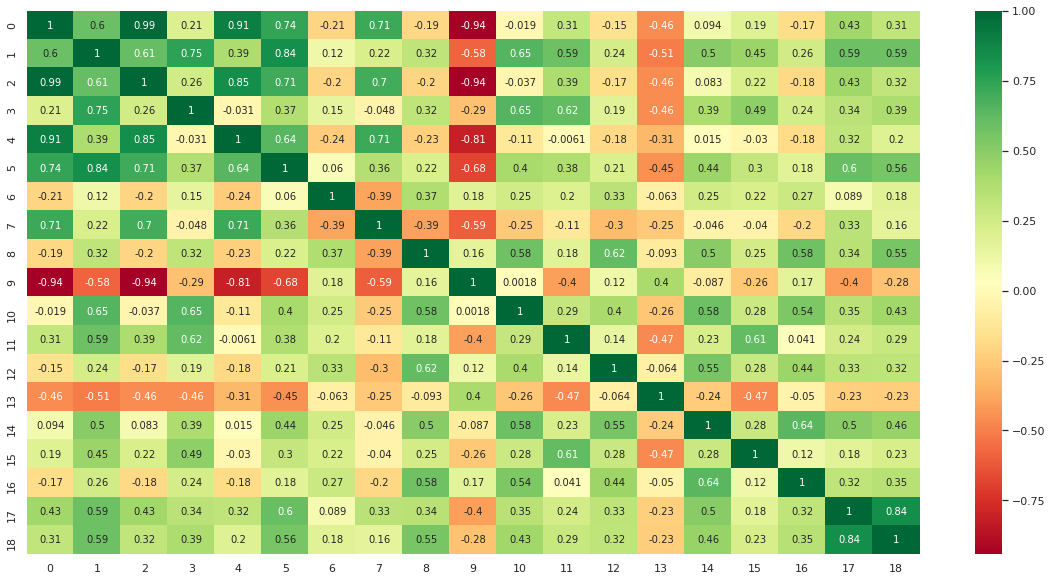

In [ ]:
plt.figure(figsize=(20,10))  # on this line I just set the size of figure to 20 by 10.
p=sns.heatmap(corr_set_2, annot=True,cmap ='RdYlGn')

#### Set1

##### Only Timbral Features

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_mat_n_set1, labels_set1_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 32.02it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 77.33333333333333 % and k = [1, 8]


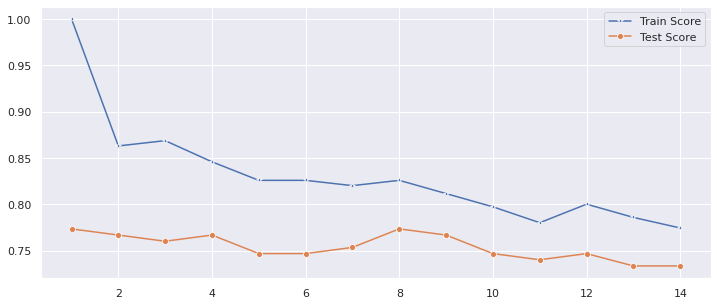

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7866666666666666


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.9142857142857143


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.72


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7866666666666666


##### Timbral Features + Rhythmic Features

In [ ]:
tr_feature_mat_set1 = np.concatenate((feature_mat_n_set1,rhythmic_features_n_set1), axis=1 )

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tr_feature_mat_set1, labels_set1_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 30.82it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 76.0 % and k = [11]


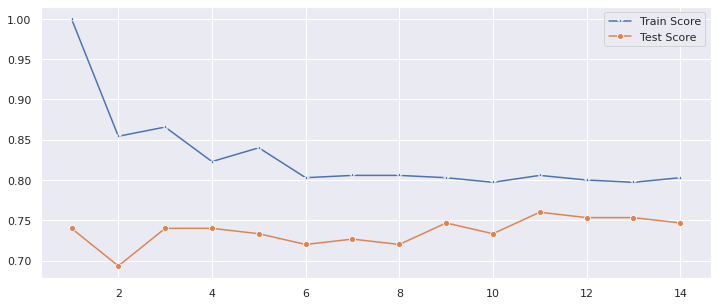

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7666666666666667


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.8714285714285714


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7066666666666667


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.78


##### Timbral Features + Rhythmic Features + Pitch Features



In [ ]:
tr_feature_mat_set1 = np.concatenate((feature_mat_n_set1,rhythmic_features_n_set1), axis=1 )
trp_feature_mat_set1 = np.concatenate((tr_feature_mat_set1, pitch_feature_n_set1), axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(trp_feature_mat_set1, labels_set1_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 28.94it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 76.66666666666667 % and k = [14]


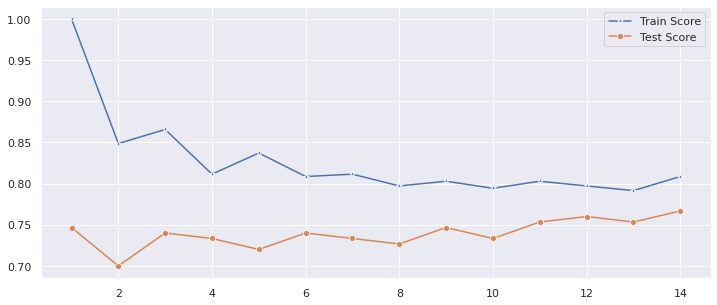

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7533333333333333


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.8714285714285714


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7066666666666667


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7733333333333333


#### Set2

##### Only Timbral Features

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_mat_n_set2, labels_set2_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 31.84it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 73.33333333333333 % and k = [13]


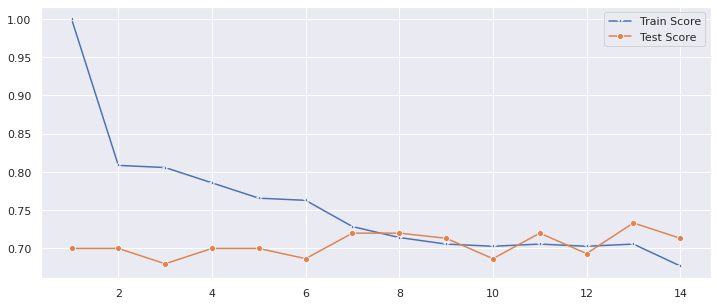

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.6333333333333333


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.42105263157894735


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.5733333333333334


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.7133333333333334


##### Timbral Features + Rhythmic Features

In [ ]:
tr_feature_mat_set2 = np.concatenate((feature_mat_n_set2,rhythmic_features_n_set2), axis=1 )

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tr_feature_mat_set2, labels_set2_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 28.78it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 66.66666666666666 % and k = [6]


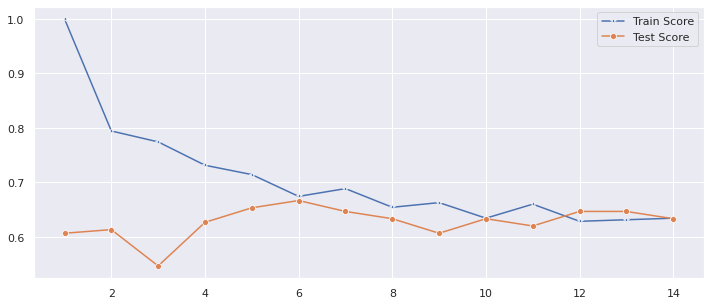

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.6733333333333333


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.49122807017543857


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.5733333333333334


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.72


##### Timbral Features + Rhythmic Features + Pitch Features



In [ ]:
tr_feature_mat_set2 = np.concatenate((feature_mat_n_set2,rhythmic_features_n_set2), axis=1 )
trp_feature_mat_set2 = np.concatenate((tr_feature_mat_set2, pitch_feature_n_set2), axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(trp_feature_mat_set2, labels_set2_numpy, train_size = 0.7,random_state = 42, shuffle = True)

100%|██████████| 14/14 [00:00<00:00, 28.75it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Max test score 62.0 % and k = [2, 9]


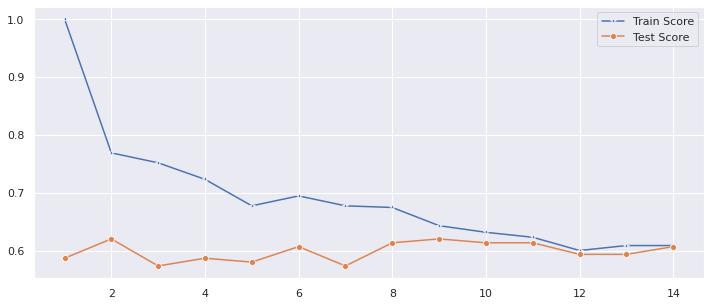

In [ ]:
# K nearest neighbours
train_scores, test_scores = knn_model(x_train,y_train,x_test,y_test)
knn_get_visualization(train_scores, test_scores)

In [ ]:
# Logistic Regression
logReg_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.66


In [ ]:
# SVM 
svm_model(x_train,y_train,x_test,y_test)

The accuracy is: 0.5263157894736842


In [ ]:
# Decision Trees
dt_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.5733333333333334


In [ ]:
# random forest 
rf_model(x_train,y_train,x_test,y_test)

The accuracy is:  0.76
